# Tutorial 02: Exploring ShoreTrans Translation Types (Rollover vs Encroachment)

This notebook walks you through the different profile translation types available in ShoreTrans.
You will learn how the model behaves under various barrier responses:

1. Type 1 : Full Rollover (onshore transport)
2. Type 2 : Dune crest keeps up with sea level rise
3. Type 3 : Rollover but maintain initial crest height
4. Type 4 : Encroachment (offshore transport)

Each type represents a different real-world coastal behavior. By the end of this tutorial, youll understand
how to choose and configure the appropriate response type based on your site.

In [1]:
import os
import shutil
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Setup tutorial environment ---
base_dir = Path.cwd()
tutorial_dir = base_dir
input_dir = tutorial_dir / "inputs"
output_dir = tutorial_dir / "outputs"
tutorial_dir.mkdir(parents=True, exist_ok=True)
input_dir.mkdir(exist_ok=True)
output_dir.mkdir(exist_ok=True)

# --- Copy a representative profile (e.g. low barrier with lagoon) ---
transect_source = base_dir.parent / "data" / "barrier_4.txt"
transect_target = input_dir / "transect.txt"
shutil.copy(transect_source, transect_target);


In [2]:
## add helper functions

# --- Function to write parameters file ---
def write_parameters(params: dict, filepath: Path):
    with open(filepath, "w") as f:
        for key, val in params.items():
            f.write(f"{key} = {val}\n")

# --- Run ShoreTrans for each type ---
def run_shoretrans():
    if not shutil.which("shoretrans"):
        raise RuntimeError("'shoretrans' binary not found in PATH.")

    process = subprocess.Popen(
        ["shoretrans", str(tutorial_dir)],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    for line in process.stdout:
        print(line.decode().strip())

In the following loop, we configure and run ShoreTrans four times, each using a different rollover strategy.

All runs apply the same sea level rise of **1 meter** (`ds = 1.0`) to the same profile, but each one reflects a different
translation mechanism for the barrier or dune feature. These types are defined as follows (based on McCarroll et al., 2021):

- **Type 1: Full Rollover**
  - Represents an unconstrained barrier where the entire profile, including the dune crest, rolls landward.
  - Volume is conserved and redistributed onshore.
  - Crest height and barrier geometry are preserved but shifted landward.
  - We use `toe_crest_index` to specify the barrier's start.

- **Type 2: Rollover with crest keep-up**
  - The dune crest not only rolls over but also rises to match sea level rise.
  - Simulates a natural or managed barrier that grows vertically as sea level rises (e.g., via aeolian deposition or nourishment).

- **Type 3: Rollover with fixed crest**
  - Similar to Type 2, but the dune crest is not allowed to rise.
  - Simulates an eroding or constrained barrier where the crest height is fixed (e.g., due to vegetation, structures, or morphology).

- **Type 4: Encroachment (No Rollover)**
  - No rollover occurs.
  - Profile translates offshore instead, simulating scarping, cliff retreat, or armoring.
  - Often associated with hard or erodible barriers where sediment cannot be pushed inland.

for more information, please check the original paper [here](https://www.sciencedirect.com/science/article/pii/S0025322721000487)

In [3]:
## set up common parameters
common = {
    "xshorefilename": 'transect.txt',
    "doc": -10,
    "ds": 1.0,
    "dx": 1,
    "roll_backslope": 4}

# --- Load initial profile ---
initial_profile = np.loadtxt(transect_target, delimiter=",", skiprows=1)
x = initial_profile[:, 0]
z0 = initial_profile[:, 1]

## Type 1: Full Rollover

This represents a freely migrating barrier.

The entire barrier including its crest is allowed to move landward, preserving its shape and elevation.

This simulates a natural barrier backed by a lagoon or flatland, with no hard constraints.

This is done by setting the 'rollover' setting to 1 (i.e rolling allowed), and the 'toe_crest' or 'toe_crest_index' to a value matching the dune back 

Here, we define the toe of the crest based on the lagoon toe elevation (e.g., -1.5 m).
We find the index of the first point in the profile that exceeds this elevation.

In [4]:
lagoon_toe_z = -1.5
lagoon_toe_ind = int(round((x[np.where(z0 > -1.5)[0][0]] - x[0]) / common['dx'])) # we need to find the index of the toe after reinterpolating at uniform dx

params1 = common.copy()
params1.update({
    "toe_crest_index": lagoon_toe_ind,
    "rollover": 1
})
write_parameters(params1, tutorial_dir / "parameters.dat")
run_shoretrans()
z1 = np.loadtxt(output_dir / "z_final.out")[:, 1]

Depth of closure 2 not set, using doc2= -10.10000000
Final xi:   -58.0000 m (     -58 grid points)
Final volume error (dv): -2.88741940 m3
saving final profile to: /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/02_translation_types/z_final.out
Program finished in      0.003 seconds.


## Type 2: Crest keep-up

assumes the crest elevation increases with sea level. 

This simulates aeolian deposition or management (like dune building) keeping the crest aligned with rising sea level.

The only difference with the previous case is that here the toe_crest is set to the max of the profile.

 You can either set this manually, or simply by omiting the parameter.

In [5]:
params2 = common.copy()
params2.update({
    "rollover": 1
})
write_parameters(params2, tutorial_dir / "parameters.dat")
run_shoretrans()
z2 = np.loadtxt(output_dir / "z_final.out")[:, 1]

none of the toe/crest values were set, using the maximum of the profile
Depth of closure 2 not set, using doc2= -10.10000000
Final xi:   -30.0000 m (     -30 grid points)
Final volume error (dv): 2.49098244 m3
saving final profile to: /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/02_translation_types/z_final.out
Program finished in      0.003 seconds.


## Type 3: Crest fixed

keeps the crest height constant as it rolls over.

This represents barriers with vegetation or development that prevent vertical growth.

This is done by setting the rollover parameter to 2. (the toe_crest is also the max of the profile).

In [6]:
params3 = params2.copy()
params3["rollover"] = 2
write_parameters(params3, tutorial_dir / "parameters.dat")
run_shoretrans()
z3 = np.loadtxt(output_dir / "z_final.out")[:, 1]

none of the toe/crest values were set, using the maximum of the profile
Depth of closure 2 not set, using doc2= -10.10000000
Final xi:   -25.0000 m (     -25 grid points)
Final volume error (dv): 0.60592308 m3
saving final profile to: /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/02_translation_types/z_final.out
Program finished in      0.003 seconds.


## Type 4: Encroachment 
This disables rollover (default). The shoreline adjusts seaward, and the profile steepens.


This is common in eroding coasts or where hard barriers exist.

In [7]:
params4 = params2.copy()
params4["rollover"] = 0
write_parameters(params4, tutorial_dir / "parameters.dat")
run_shoretrans()
z4 = np.loadtxt(output_dir / "z_final.out")[:, 1]

none of the toe/crest values were set, using the maximum of the profile
Depth of closure 2 not set, using doc2= -10.10000000
Final xi:   -22.0000 m (     -22 grid points)
Final volume error (dv): -5.31001346 m3
saving final profile to: /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/02_translation_types/z_final.out
Program finished in      0.004 seconds.


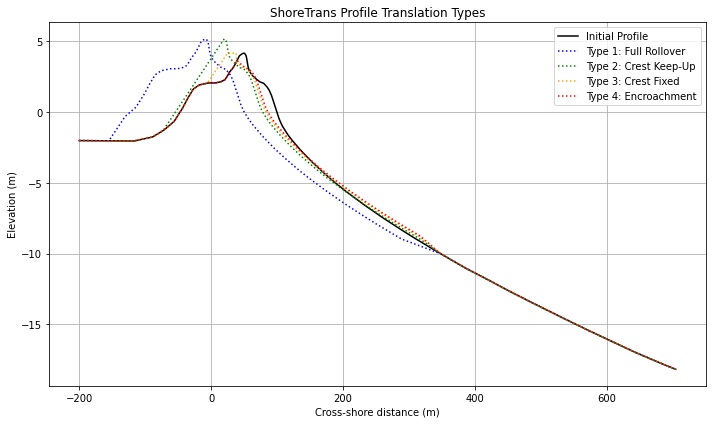

In [8]:
# NOTE: Since ShoreTrans uses uniform dx, we use the initial profile saved by the model itself
initial_profile = np.loadtxt(output_dir / "initial_profile.out")
x = initial_profile[:, 0]
z0 = initial_profile[:, 1]

# --- Plot all results ---
plt.figure(figsize=(10,6))
plt.plot(x, z0, 'k', label="Initial Profile")
plt.plot(x, z1, ':b', label="Type 1: Full Rollover")
plt.plot(x, z2, ':g', label="Type 2: Crest Keep-Up")
plt.plot(x, z3, color='orange', linestyle=':', label="Type 3: Crest Fixed")
plt.plot(x, z4, ':r', label="Type 4: Encroachment")
plt.title("ShoreTrans Profile Translation Types")
plt.xlabel("Cross-shore distance (m)")
plt.ylabel("Elevation (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()